## Part B

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import requests
import json
import numpy as np
from numpy import mean, where
import sklearn
from sklearn import metrics

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample, shuffle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request as ul
import time
import glob

In [2]:
# Load the cleaned dataset 

partB = pd.read_csv("/Users/buynow/Desktop/Business Analytics Practicum/IntegrityM/PartB/Datasets/partB_new.csv")

In [3]:
partB.head()

,NPI,Gender,Type,Tot_Benes_mean,Tot_Benes_sum,Tot_Benes_median,Tot_Benes_std,Tot_Benes_min,Tot_Benes_max,Tot_Srvcs_mean,...,Avg_Sbmtd_Chrg_std,Avg_Sbmtd_Chrg_min,Avg_Sbmtd_Chrg_max,Avg_Mdcr_Pymt_Amt_mean,Avg_Mdcr_Pymt_Amt_sum,Avg_Mdcr_Pymt_Amt_median,Avg_Mdcr_Pymt_Amt_std,Avg_Mdcr_Pymt_Amt_min,Avg_Mdcr_Pymt_Amt_max,Fraud
0,1003000126,M,Internal Medicine,123.811594,8543,85.0,123.864641,11,596,184.521739,...,291.214723,97.000000,1400.0,95.243313,6571.788575,82.588165,42.552226,30.065246,179.000000,0
1,1003000134,M,Pathology,482.643836,35233,117.0,1083.822830,11,4488,796.479452,...,67.281013,40.000000,350.0,29.674687,2166.252185,29.137817,17.104918,9.090000,72.372727,0
2,1003000142,M,Anesthesiology,39.130435,3600,26.5,32.837334,11,140,61.858696,...,163.261343,18.000000,1105.0,76.259796,7015.901211,67.053038,43.518787,9.066741,243.684848,0
3,1003000407,M,Family Practice,50.852941,5187,34.0,44.930176,11,187,71.598039,...,96.306115,54.894118,621.0,83.769771,8544.516622,79.500930,36.181181,27.841081,173.400000,0
4,1003000423,F,Obstetrics & Gynecology,25.214286,353,20.0,12.903062,11,50,26.357143,...,46.925111,40.000000,200.0,48.074944,673.049214,41.295000,15.916244,35.490000,89.030000,0


In [4]:
partB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567485 entries, 0 to 1567484
Data columns (total 34 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   NPI                        1567485 non-null  int64  
 1   Gender                     1567485 non-null  object 
 2   Type                       1567485 non-null  object 
 3   Tot_Benes_mean             1567485 non-null  float64
 4   Tot_Benes_sum              1567485 non-null  int64  
 5   Tot_Benes_median           1567485 non-null  float64
 6   Tot_Benes_std              1567485 non-null  float64
 7   Tot_Benes_min              1567485 non-null  int64  
 8   Tot_Benes_max              1567485 non-null  int64  
 9   Tot_Srvcs_mean             1567485 non-null  float64
 10  Tot_Srvcs_sum              1567485 non-null  float64
 11  Tot_Srvcs_median           1567485 non-null  float64
 12  Tot_Srvcs_std              1567485 non-null  float64
 13  Tot_Srvcs_mi

### Ratio of Fraud and Non-fraud classes 

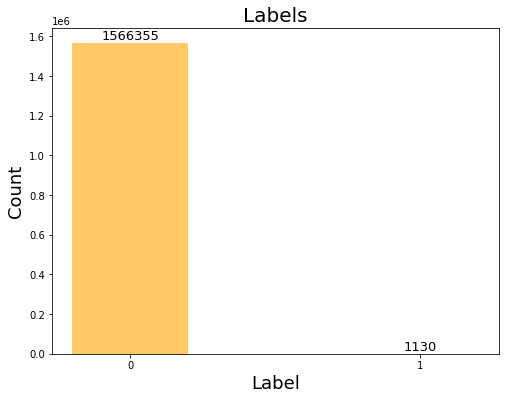

In [5]:
fig = plt.figure(figsize=(8, 6))

# Plot the bar graph
Y_fraud = list(partB["Fraud"].value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Labels", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
 
# Display the graph on the screen
plt.show()

In [6]:
ratio = partB["Fraud"].value_counts(normalize = True) 
print("Fraud: ", round(ratio[0]*100, 2), "%")
print("Non-Fraud: ", round(ratio[1]*100, 2), "%")

Fraud:  99.93 %
Non-Fraud:  0.07 %


### Normalization

In [7]:
list(partB.columns)

['NPI',
 'Gender',
 'Type',
 'Tot_Benes_mean',
 'Tot_Benes_sum',
 'Tot_Benes_median',
 'Tot_Benes_std',
 'Tot_Benes_min',
 'Tot_Benes_max',
 'Tot_Srvcs_mean',
 'Tot_Srvcs_sum',
 'Tot_Srvcs_median',
 'Tot_Srvcs_std',
 'Tot_Srvcs_min',
 'Tot_Srvcs_max',
 'Tot_Bene_Day_Srvcs_mean',
 'Tot_Bene_Day_Srvcs_sum',
 'Tot_Bene_Day_Srvcs_median',
 'Tot_Bene_Day_Srvcs_std',
 'Tot_Bene_Day_Srvcs_min',
 'Tot_Bene_Day_Srvcs_max',
 'Avg_Sbmtd_Chrg_mean',
 'Avg_Sbmtd_Chrg_sum',
 'Avg_Sbmtd_Chrg_median',
 'Avg_Sbmtd_Chrg_std',
 'Avg_Sbmtd_Chrg_min',
 'Avg_Sbmtd_Chrg_max',
 'Avg_Mdcr_Pymt_Amt_mean',
 'Avg_Mdcr_Pymt_Amt_sum',
 'Avg_Mdcr_Pymt_Amt_median',
 'Avg_Mdcr_Pymt_Amt_std',
 'Avg_Mdcr_Pymt_Amt_min',
 'Avg_Mdcr_Pymt_Amt_max',
 'Fraud']

In [8]:
norm_partB = partB.copy()

In [9]:
norm_partB.iloc[:,3:33].head(5)

,Tot_Benes_mean,Tot_Benes_sum,Tot_Benes_median,Tot_Benes_std,Tot_Benes_min,Tot_Benes_max,Tot_Srvcs_mean,Tot_Srvcs_sum,Tot_Srvcs_median,Tot_Srvcs_std,...,Avg_Sbmtd_Chrg_median,Avg_Sbmtd_Chrg_std,Avg_Sbmtd_Chrg_min,Avg_Sbmtd_Chrg_max,Avg_Mdcr_Pymt_Amt_mean,Avg_Mdcr_Pymt_Amt_sum,Avg_Mdcr_Pymt_Amt_median,Avg_Mdcr_Pymt_Amt_std,Avg_Mdcr_Pymt_Amt_min,Avg_Mdcr_Pymt_Amt_max
0,123.811594,8543,85.0,123.864641,11,596,184.521739,12732.0,96.0,254.677975,...,416.546218,291.214723,97.000000,1400.0,95.243313,6571.788575,82.588165,42.552226,30.065246,179.000000
1,482.643836,35233,117.0,1083.822830,11,4488,796.479452,58143.0,209.0,1848.831020,...,147.000000,67.281013,40.000000,350.0,29.674687,2166.252185,29.137817,17.104918,9.090000,72.372727
2,39.130435,3600,26.5,32.837334,11,140,61.858696,5691.0,36.0,65.062874,...,160.636364,163.261343,18.000000,1105.0,76.259796,7015.901211,67.053038,43.518787,9.066741,243.684848
3,50.852941,5187,34.0,44.930176,11,187,71.598039,7303.0,39.0,80.520492,...,144.285714,96.306115,54.894118,621.0,83.769771,8544.516622,79.500930,36.181181,27.841081,173.400000
4,25.214286,353,20.0,12.903062,11,50,26.357143,369.0,20.5,12.456738,...,51.046512,46.925111,40.000000,200.0,48.074944,673.049214,41.295000,15.916244,35.490000,89.030000


In [10]:
normalized_B=(norm_partB.iloc[:,3:33]-norm_partB.iloc[:,3:33].mean())/norm_partB.iloc[:,3:33].std()

In [11]:
normalized_B.head(5)

,Tot_Benes_mean,Tot_Benes_sum,Tot_Benes_median,Tot_Benes_std,Tot_Benes_min,Tot_Benes_max,Tot_Srvcs_mean,Tot_Srvcs_sum,Tot_Srvcs_median,Tot_Srvcs_std,...,Avg_Sbmtd_Chrg_median,Avg_Sbmtd_Chrg_std,Avg_Sbmtd_Chrg_min,Avg_Sbmtd_Chrg_max,Avg_Mdcr_Pymt_Amt_mean,Avg_Mdcr_Pymt_Amt_sum,Avg_Mdcr_Pymt_Amt_median,Avg_Mdcr_Pymt_Amt_std,Avg_Mdcr_Pymt_Amt_min,Avg_Mdcr_Pymt_Amt_max
0,1.466724,0.783813,1.370714,1.107226,-0.18971,1.116986,0.305508,0.596617,0.129397,0.384654,...,0.379835,0.101518,-0.063663,0.166574,0.462152,0.582107,0.620599,-0.047389,0.199928,-0.062891
1,8.865275,4.481157,2.279859,14.903408,-0.18971,12.037718,3.466550,4.206416,0.935987,5.636781,...,-0.277353,-0.316821,-0.288146,-0.290708,-0.721138,-0.134186,-0.706553,-0.348907,-0.514040,-0.310165
2,-0.279267,0.099064,-0.291315,-0.200986,-0.18971,-0.162524,-0.328103,0.036916,-0.298881,-0.240056,...,-0.244106,-0.137517,-0.374788,0.038100,0.119564,0.654315,0.234868,-0.035936,-0.514832,0.087116
3,-0.037567,0.318910,-0.078234,-0.027192,-0.18971,-0.030645,-0.277795,0.165057,-0.277467,-0.189129,...,-0.283971,-0.262598,-0.229488,-0.172686,0.255094,0.902851,0.543944,-0.122877,0.124220,-0.075878
4,-0.566196,-0.350740,-0.475985,-0.487475,-0.18971,-0.415059,-0.511485,-0.386139,-0.409519,-0.413373,...,-0.511300,-0.354849,-0.288146,-0.356034,-0.389076,-0.376964,-0.404695,-0.362991,0.384579,-0.271536


In [12]:
N1 = normalized_B.join(partB['NPI'])

In [13]:
N2 = N1.join(partB['Gender'])

In [14]:
N3 = N2.join(partB['Type'])

In [15]:
partB_N = N3.join(partB['Fraud'])

In [16]:
partB_N.head(5)

,Tot_Benes_mean,Tot_Benes_sum,Tot_Benes_median,Tot_Benes_std,Tot_Benes_min,Tot_Benes_max,Tot_Srvcs_mean,Tot_Srvcs_sum,Tot_Srvcs_median,Tot_Srvcs_std,...,Avg_Mdcr_Pymt_Amt_mean,Avg_Mdcr_Pymt_Amt_sum,Avg_Mdcr_Pymt_Amt_median,Avg_Mdcr_Pymt_Amt_std,Avg_Mdcr_Pymt_Amt_min,Avg_Mdcr_Pymt_Amt_max,NPI,Gender,Type,Fraud
0,1.466724,0.783813,1.370714,1.107226,-0.18971,1.116986,0.305508,0.596617,0.129397,0.384654,...,0.462152,0.582107,0.620599,-0.047389,0.199928,-0.062891,1003000126,M,Internal Medicine,0
1,8.865275,4.481157,2.279859,14.903408,-0.18971,12.037718,3.466550,4.206416,0.935987,5.636781,...,-0.721138,-0.134186,-0.706553,-0.348907,-0.514040,-0.310165,1003000134,M,Pathology,0
2,-0.279267,0.099064,-0.291315,-0.200986,-0.18971,-0.162524,-0.328103,0.036916,-0.298881,-0.240056,...,0.119564,0.654315,0.234868,-0.035936,-0.514832,0.087116,1003000142,M,Anesthesiology,0
3,-0.037567,0.318910,-0.078234,-0.027192,-0.18971,-0.030645,-0.277795,0.165057,-0.277467,-0.189129,...,0.255094,0.902851,0.543944,-0.122877,0.124220,-0.075878,1003000407,M,Family Practice,0
4,-0.566196,-0.350740,-0.475985,-0.487475,-0.18971,-0.415059,-0.511485,-0.386139,-0.409519,-0.413373,...,-0.389076,-0.376964,-0.404695,-0.362991,0.384579,-0.271536,1003000423,F,Obstetrics & Gynecology,0


### One-Hot Encoding

In [17]:
# One-Hot Encoding 

# Convert the Fraud variable to object datatype
partB_N["Fraud"] = partB_N["Fraud"].astype(object)

# Encoding
encoded_partB = pd.get_dummies(partB_N, drop_first = True)

# Rename some of the changed variable names
encoded_partB.rename(columns = {"Gender_M":"Gender", "Fraud_1":"Fraud"}, inplace = True)

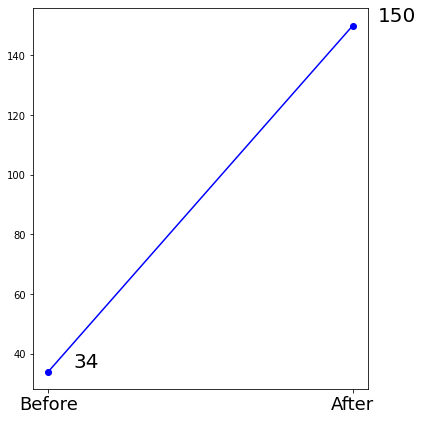

In [18]:
# Feature size of the encoded dataset 

fig, ax = plt.subplots(figsize=(6,7))

xs = ["Before", "After"]
ys = [len(partB_N.columns), len(encoded_partB.columns)]
ax.plot(xs, ys, "bo-")

for x,y in zip(xs, ys):
    label = "{:d}".format(y)
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(25,4), 
                 ha='left',
                fontsize = 20) 
    
ax.set_xticklabels(xs, fontsize=18)

plt.show()

In [19]:
list(encoded_partB.columns)

['Tot_Benes_mean',
 'Tot_Benes_sum',
 'Tot_Benes_median',
 'Tot_Benes_std',
 'Tot_Benes_min',
 'Tot_Benes_max',
 'Tot_Srvcs_mean',
 'Tot_Srvcs_sum',
 'Tot_Srvcs_median',
 'Tot_Srvcs_std',
 'Tot_Srvcs_min',
 'Tot_Srvcs_max',
 'Tot_Bene_Day_Srvcs_mean',
 'Tot_Bene_Day_Srvcs_sum',
 'Tot_Bene_Day_Srvcs_median',
 'Tot_Bene_Day_Srvcs_std',
 'Tot_Bene_Day_Srvcs_min',
 'Tot_Bene_Day_Srvcs_max',
 'Avg_Sbmtd_Chrg_mean',
 'Avg_Sbmtd_Chrg_sum',
 'Avg_Sbmtd_Chrg_median',
 'Avg_Sbmtd_Chrg_std',
 'Avg_Sbmtd_Chrg_min',
 'Avg_Sbmtd_Chrg_max',
 'Avg_Mdcr_Pymt_Amt_mean',
 'Avg_Mdcr_Pymt_Amt_sum',
 'Avg_Mdcr_Pymt_Amt_median',
 'Avg_Mdcr_Pymt_Amt_std',
 'Avg_Mdcr_Pymt_Amt_min',
 'Avg_Mdcr_Pymt_Amt_max',
 'NPI',
 'Gender',
 'Type_Advanced Heart Failure and Transplant Cardiology',
 'Type_All Other Suppliers',
 'Type_Allergy/ Immunology',
 'Type_Allergy/Immunology',
 'Type_Ambulance Service Provider',
 'Type_Ambulance Service Supplier',
 'Type_Anesthesiologist Assistants',
 'Type_Anesthesiology',
 'Type_Anest

In [20]:
encoded_partB.head(5)

,Tot_Benes_mean,Tot_Benes_sum,Tot_Benes_median,Tot_Benes_std,Tot_Benes_min,Tot_Benes_max,Tot_Srvcs_mean,Tot_Srvcs_sum,Tot_Srvcs_median,Tot_Srvcs_std,...,Type_Surgical Oncology,Type_Thoracic Surgery,Type_Undefined Physician type,Type_Undersea and Hyperbaric Medicine,Type_Unknown Physician Specialty Code,Type_Unknown Supplier/Provider,Type_Unknown Supplier/Provider Specialty,Type_Urology,Type_Vascular Surgery,Fraud
0,1.466724,0.783813,1.370714,1.107226,-0.18971,1.116986,0.305508,0.596617,0.129397,0.384654,...,0,0,0,0,0,0,0,0,0,0
1,8.865275,4.481157,2.279859,14.903408,-0.18971,12.037718,3.466550,4.206416,0.935987,5.636781,...,0,0,0,0,0,0,0,0,0,0
2,-0.279267,0.099064,-0.291315,-0.200986,-0.18971,-0.162524,-0.328103,0.036916,-0.298881,-0.240056,...,0,0,0,0,0,0,0,0,0,0
3,-0.037567,0.318910,-0.078234,-0.027192,-0.18971,-0.030645,-0.277795,0.165057,-0.277467,-0.189129,...,0,0,0,0,0,0,0,0,0,0
4,-0.566196,-0.350740,-0.475985,-0.487475,-0.18971,-0.415059,-0.511485,-0.386139,-0.409519,-0.413373,...,0,0,0,0,0,0,0,0,0,0


### Data Spliting

In [21]:
# Assign X and y features

X_var = list(encoded_partB.columns)

for var in ["NPI", "Fraud"]:
    X_var.remove(var)

y_var = "Fraud"

In [22]:
# Split the whole dataset into train and test dataset
# Using a stratified random sampling so that the Fraud-class (1) data are evenly split into train & test sets
x_train, x_test, y_train, y_test = train_test_split(encoded_partB[X_var], encoded_partB[y_var], test_size=0.3, stratify=encoded_partB["Fraud"])

# Also concatenate the split x & y dataframes 
tr_df = pd.concat([x_train, y_train], axis = 1)
te_df = pd.concat([x_test, y_test], axis = 1)

In [23]:
# Calculate the odds ratio of Fraud & Non-fraud labels for train & test sets

train_0 = len(tr_df[tr_df["Fraud"] == 0])
train_1 = len(tr_df[tr_df["Fraud"] == 1])

test_0 = len(te_df[te_df["Fraud"] == 0])
test_1 = len(te_df[te_df["Fraud"] == 1])

split_df = pd.DataFrame({"x_axis":["Train", "Test"], 
                         "Ratio":[train_1/train_0*100, test_1/test_0*100]})

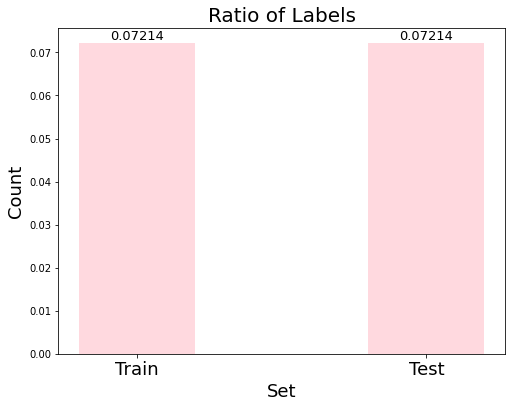

In [24]:
fig, ax = plt.subplots(figsize=(8,6))

# Plot the bar graph
plot = plt.bar(split_df["x_axis"], split_df["Ratio"], 
               width = 0.4,
              color = "pink",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%.5f' % height, ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Ratio of Labels", fontsize = 20)
plt.xlabel("Set", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

ax.set_xticklabels(split_df["x_axis"], fontsize=18)

# Display the graph on the screen
plt.show()

### Histogram

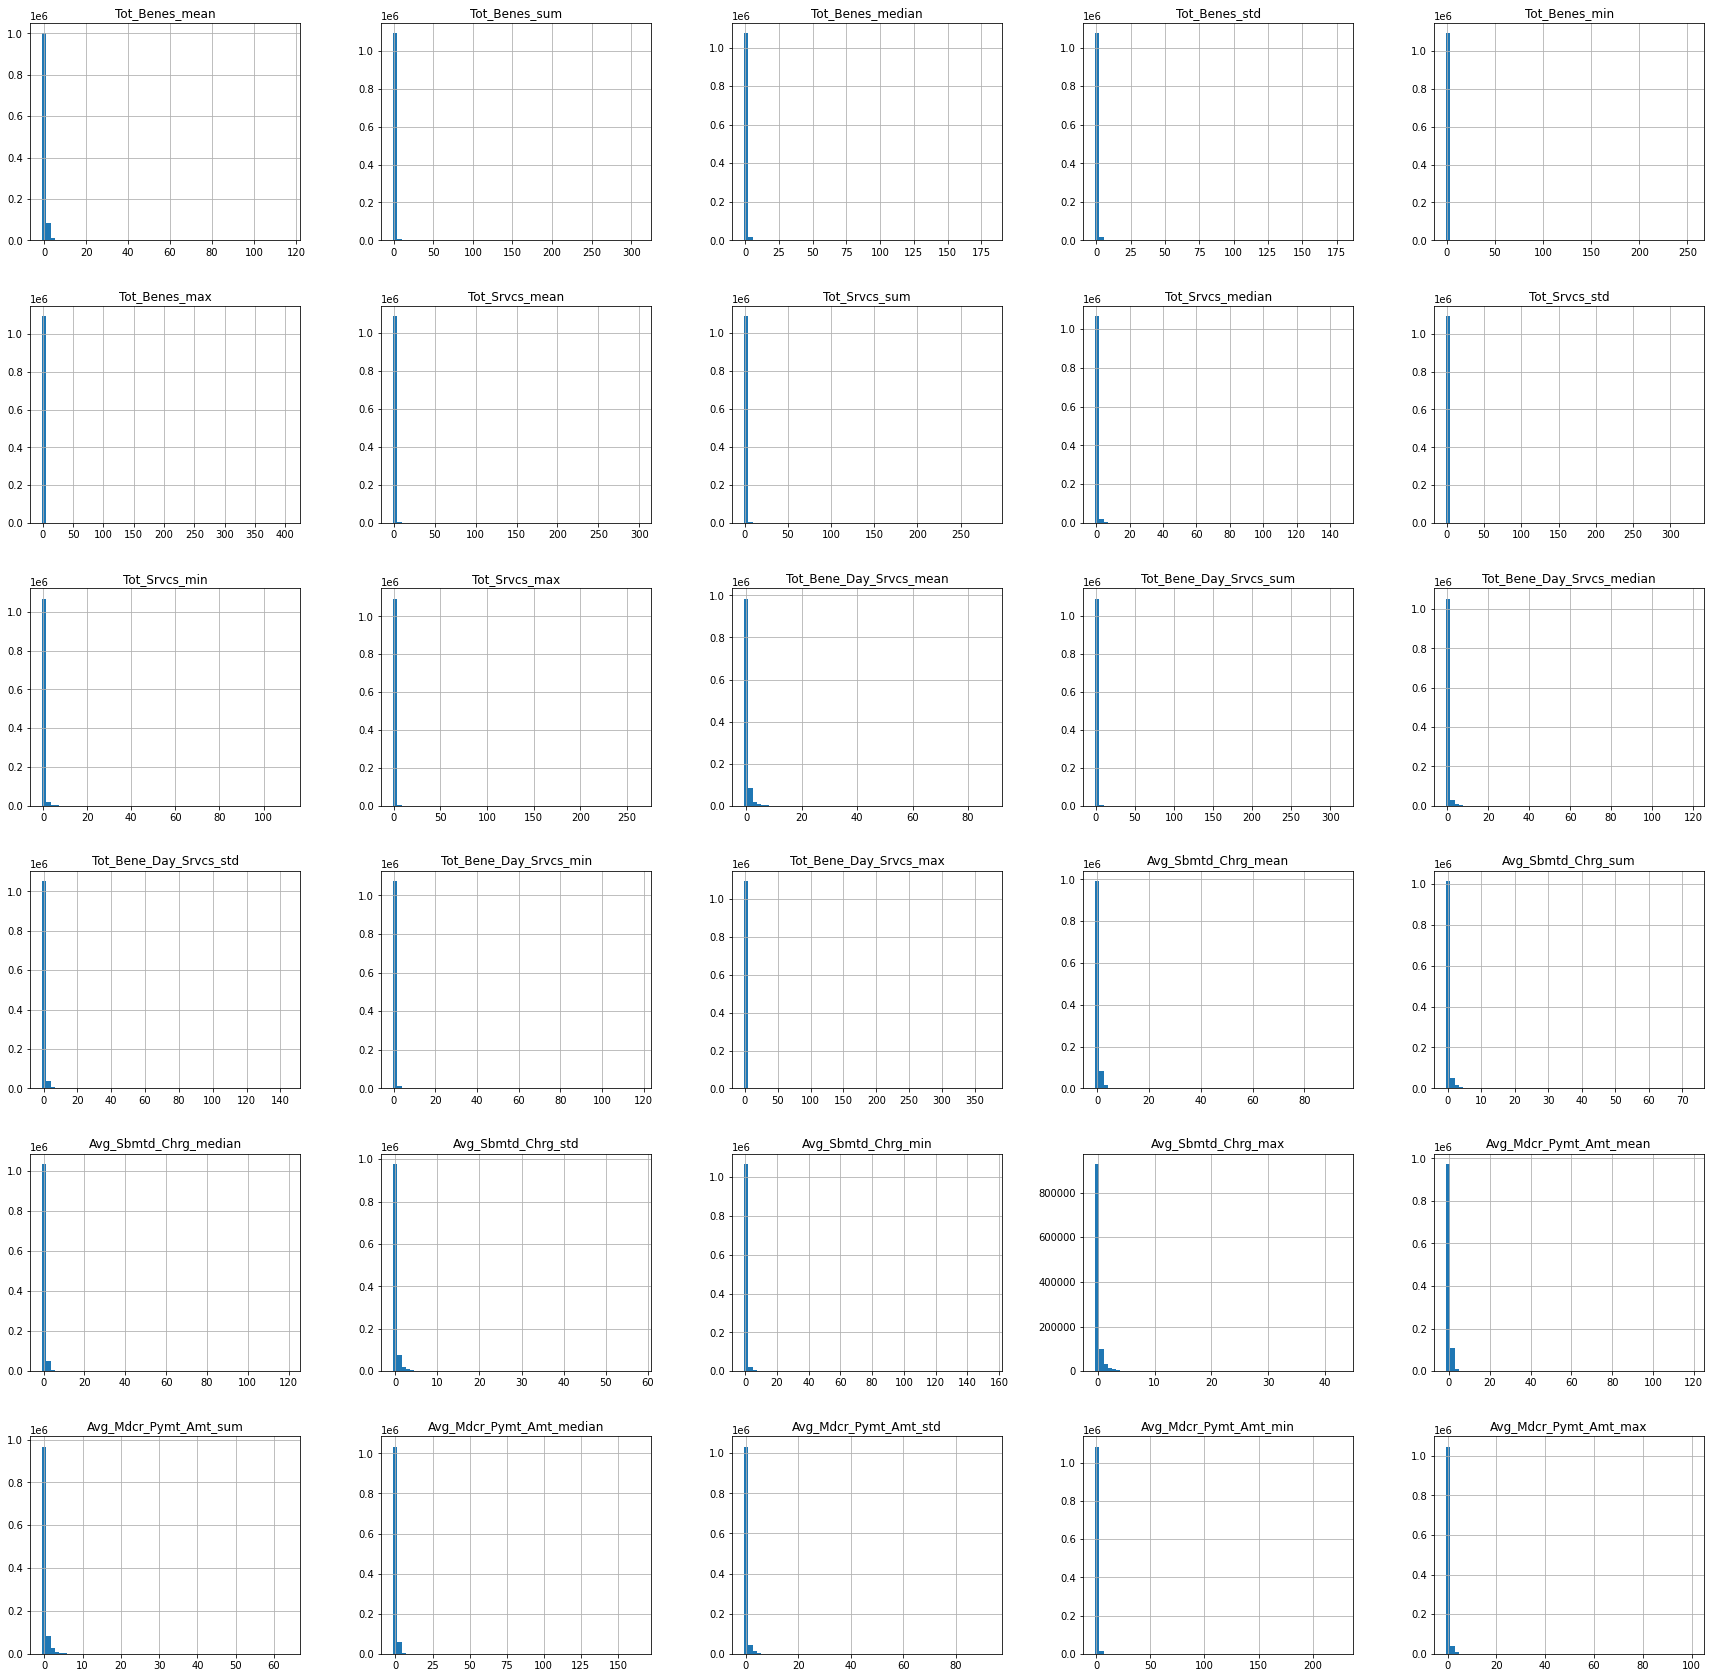

In [25]:
# Histograms

cont_features = partB_N.columns.tolist()

for var in ["NPI", "Type", "Gender", "Fraud"]:
    cont_features.remove(var)

_ = tr_df[cont_features].hist(bins=60, figsize=(30, 30))

### Heat map for correlations

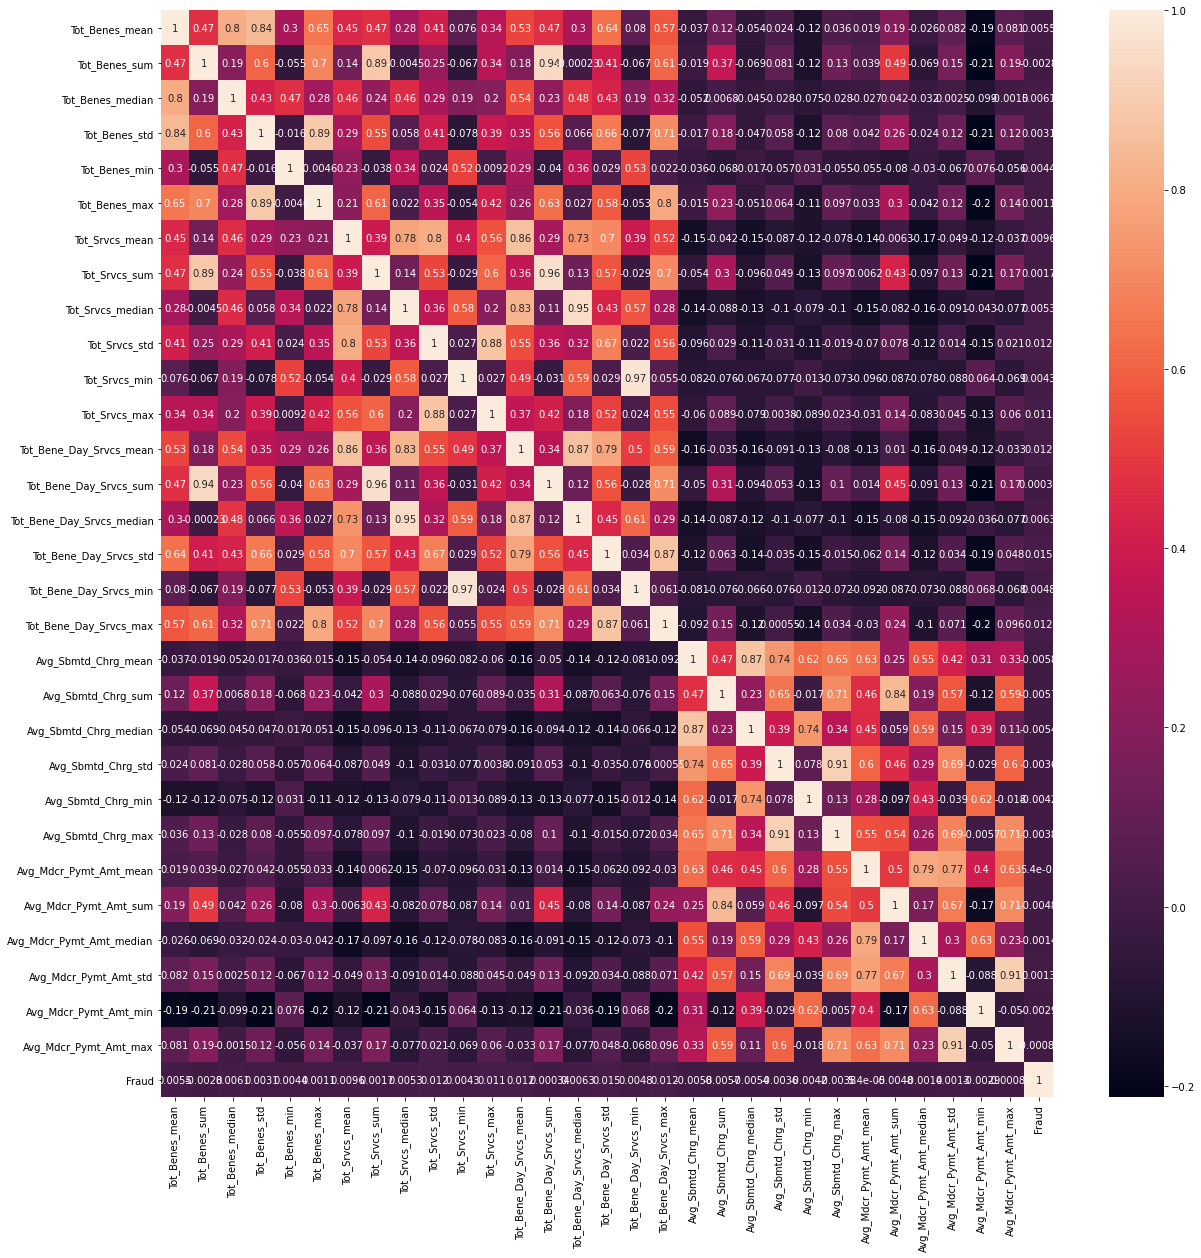

In [26]:
# Check Multicollinearity 
plt.figure(figsize = (20,20))

corr = tr_df[cont_features + [y_var]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, annot = True)

### box plot

In [27]:
# in order to draw the box plots of all the features in the same y-axis, scale the variables
scaled_tr = pd.DataFrame(scale(tr_df[cont_features]), columns = cont_features)

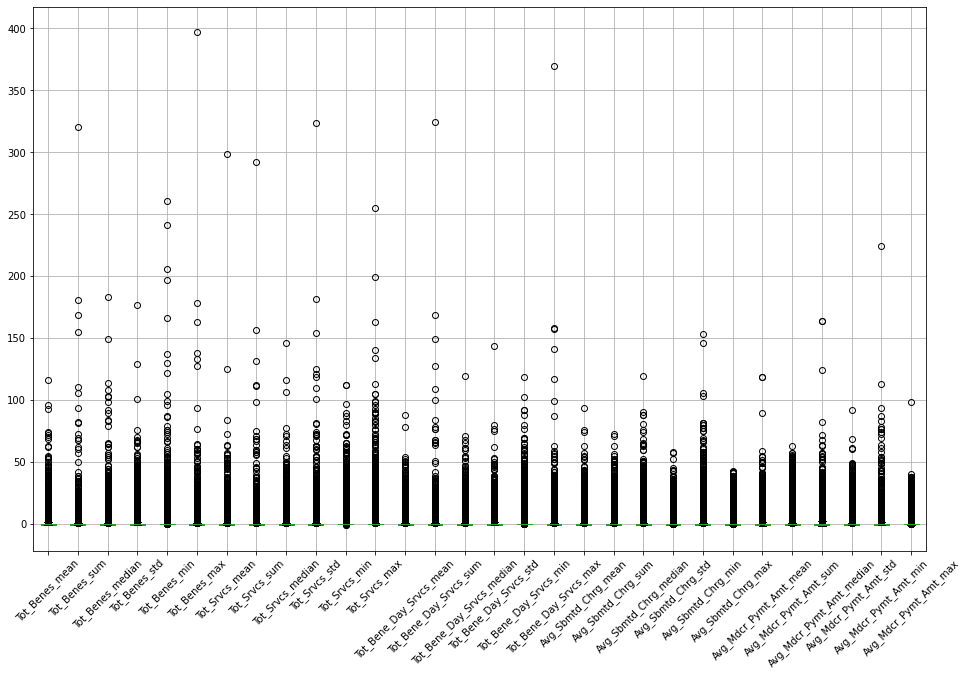

In [28]:
# box plots for the continous variables 
plt.figure(figsize=(16, 10))

scaled_tr.boxplot()
plt.xticks(rotation=45)
plt.show()

# -------SMOTE-------

In [29]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [30]:
import imblearn
print(imblearn.__version__)

0.8.1


Counter({0: 1096448, 1: 791})


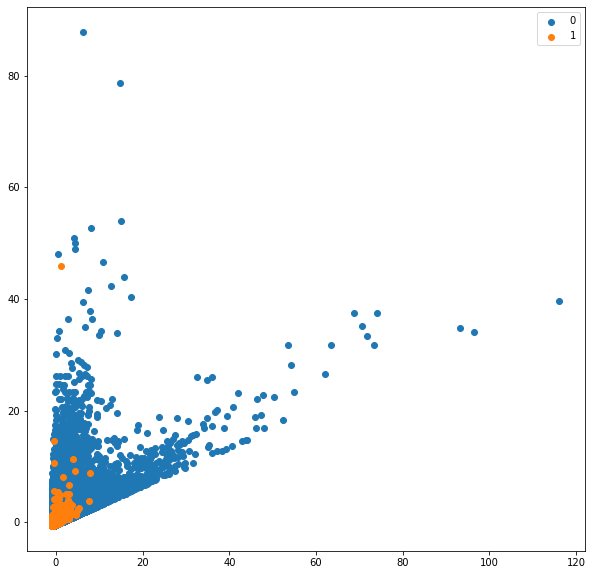

In [31]:
# scatter plot of the imbalanced data
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

from numpy import where

plt.figure(figsize=(10, 10))

counter = Counter(y_train)
print(counter)

for label, _ in counter.items():
    row_ix = where(y_train == label)[0]
    plt.scatter(x_train.iloc[row_ix, 0], x_train.iloc[row_ix, 12], label=str(label))

plt.legend()
plt.show()

### Oversampling and plot imbalanced dataset with SMOTE

In [32]:
# transform the dataset
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

oversample = over_sampling.SMOTE()
smote_trX, smote_trY = oversample.fit_resample(x_train, y_train)

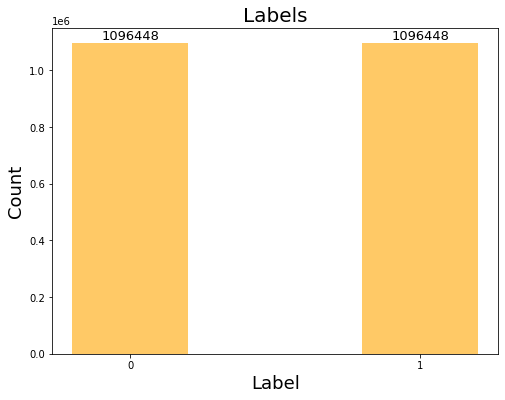

In [33]:
# After SMOTE transforming the data
fig = plt.figure(figsize=(8, 6))

# Plot the bar graph
Y_fraud = list(smote_trY.value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Labels", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
 
# Display the graph on the screen
plt.show()

Counter({0: 1096448, 1: 1096448})


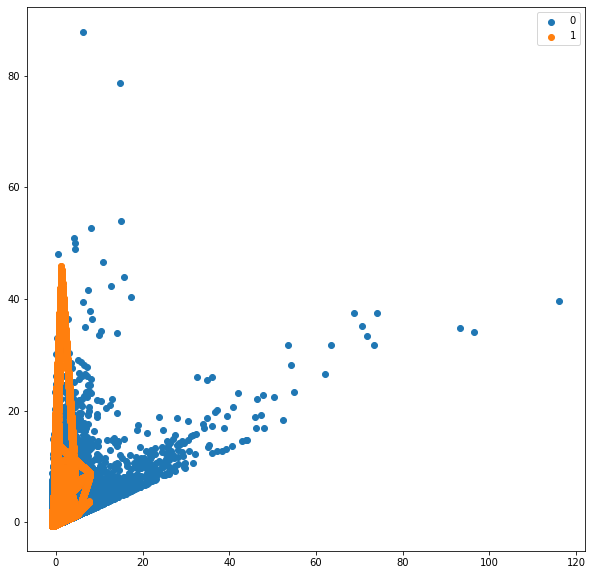

In [34]:
# scatter plot of the data transformed by SMOTE 
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter_x = Counter(smote_trY)
print(counter_x)

for label, _ in counter.items():
    row_ix = where(smote_trY == label)[0]
    plt.scatter(smote_trX.iloc[row_ix, 0], smote_trX.iloc[row_ix, 12], label=str(label))
plt.legend()
plt.show()